# Project: Movie Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This analysis covers data from 10,000 movies collected from The Movie Database (TMDb). Through this project, I examine the revenues of movies (adjusted to 2010 dollars) to determine how the profitability of movies has changed over time. Additionally, I examine other interesting qualities of movies, such as their duration and popularity of genres.

<a id='wrangling'></a>
## Data Wrangling
### Setup the Environment

In [1]:
# import libraries and set inline plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

% matplotlib inline

In [2]:
# Load data
mdb = pd.read_csv('tmdb-movies.csv', index_col=0, parse_dates=['release_date'])

# Drop unused columns, ignore errors if column doesn't exist (due to rerunning code)
mdb.drop(columns=['imdb_id', 'homepage', 'overview', 'tagline'], inplace=True, errors='ignore')

In [3]:
# Look at data in columns
mdb.head(4)

,popularity,budget,revenue,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
id,,,,,,,,,,,,,,,,
265208,2.932340,30000000,0,Wild Card,Jason Statham|Michael Angarano|Milo Ventimigli...,Simon West,gambling|bodyguard|remake,92,Thriller|Crime|Drama,Current Entertainment|Lionsgate|Sierra / Affin...,2015-01-14,481,5.3,2015,27599987.86,0
334074,2.331636,20000000,0,Survivor,Pierce Brosnan|Milla Jovovich|Dylan McDermott|...,James McTeigue,new year's eve|fire|showdown|terrorist|embassy,96,Crime|Thriller|Action,Nu Image Films|Winkler Films|Millennium Films|...,2015-05-21,280,5.4,2015,18399991.9,0
347096,2.165433,0,0,Mythica: The Darkspore,Melanie Stone|Kevin Sorbo|Adam Johnson|Jake St...,Anne K. Black,sword|magic|sorcery|necromancer|woman director,108,Action|Adventure|Fantasy,Arrowstorm Entertainment,2015-06-24,27,5.1,2015,0,0
308369,2.141506,0,0,Me and Earl and the Dying Girl,Thomas Mann|RJ Cyler|Olivia Cooke|Connie Britt...,Alfonso Gomez-Rejon,tattoo|high school|leukemia|friends|parody,105,Comedy|Drama,Indian Paintbrush,2015-06-12,569,7.7,2015,0,0


In [4]:
# Check data types of columns
mdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10866 entries, 265208 to 19995
Data columns (total 16 columns):
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
director                10822 non-null object
keywords                9373 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null datetime64[ns]
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              10866 non-null object
revenue_adj             10866 non-null object
dtypes: datetime64[ns](1), float64(2), int64(5), object(8)
memory usage: 1.4+ MB


### Data Cleaning
#### Set Data Types
Set data types for *Adj. Budget* and *Adj. Revenue* to **float**.

In [5]:
# remove extraneous punctuation and spacing, convert to number
c = ['budget_adj', 'revenue_adj']

for k in c:
    mdb[k] = (mdb[k].str.replace('$', '').str.replace(',', '').str.strip())
    mdb[k] = mdb[k].apply(pd.to_numeric)

#### Replace Zero Budget / Revenue with NaN
Replace zero values for *Budget*, *Revenue*, *Adj. Budget*, and *Adj. Revenue* with NaN so that they do not influence aggregations.

In [6]:
c = ['budget', 'revenue', 'budget_adj', 'revenue_adj']
# replace 0 with NaN in columns
mdb[c] = mdb[c].replace(0, np.nan);

#### Split / Stack Delimited List Columns
Split columns that have delimited lists of data to separate DataFrames for later joining and easier analysis.
This technique was adpated from: https://stackoverflow.com/a/28182629

In [7]:
# Split DataFrame row values at delimiter, convert row values to Series,
# Stack Series, reset Index, Drop Level identifier, Rename auto-numbered column
def split_stack_drop(s: str):
    x = mdb[s].str.split('|').apply(pd.Series).stack().reset_index().drop(columns='level_1').rename(columns={0: s})
    mdb.drop(columns=s, inplace=True)
    return x

# 'Split, Stack, and Drop' Cast, Keywords, Genres, and Production Companies
cdb = split_stack_drop('cast')
kdb = split_stack_drop('keywords')
gdb = split_stack_drop('genres')
pdb = split_stack_drop('production_companies')

<a id='eda'></a>
## Data Analysis

### How have movie Budgets and Revenues changed over time?

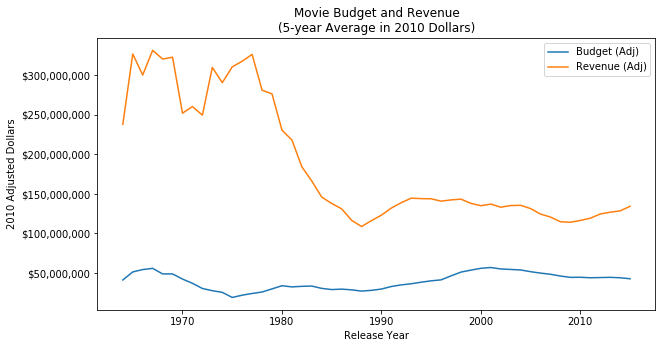

In [92]:
# include only movies that have budget and revenue; get 5-year rolling average
p = mdb[mdb['revenue_adj'].notna() & mdb['budget_adj'].notna()]
p = p.groupby('release_year').mean()
p = p[['budget_adj', 'revenue_adj']].rolling(center=False, window=5).mean()

# create chart
ax = p[['budget_adj', 'revenue_adj']].plot(title='Movie Budget and Revenue\n(5-year Average in 2010 Dollars)', figsize=(10,5))
ax.set(xlabel='Release Year', ylabel='2010 Adjusted Dollars')
ax.legend(['Budget (Adj)', 'Revenue (Adj)'])
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'));

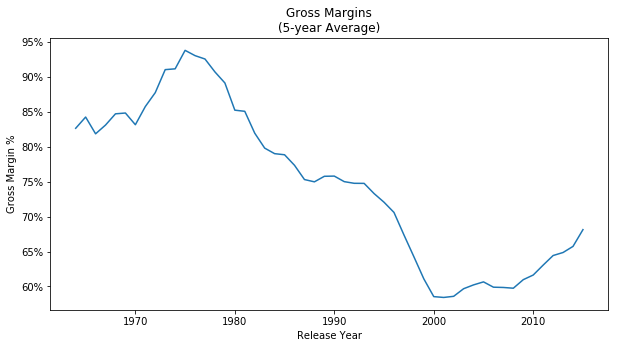

In [110]:
# Calculate margins
p['margin_adj'] = (p['revenue_adj'] - p['budget_adj']) / p['revenue_adj']

# create chart
ax = p['margin_adj'].plot(title='Gross Margins\n(5-year Average)', figsize=(10,5))
ax.set(xlabel='Release Year', ylabel='Gross Margin %')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0));

### How has movie length changed over time?

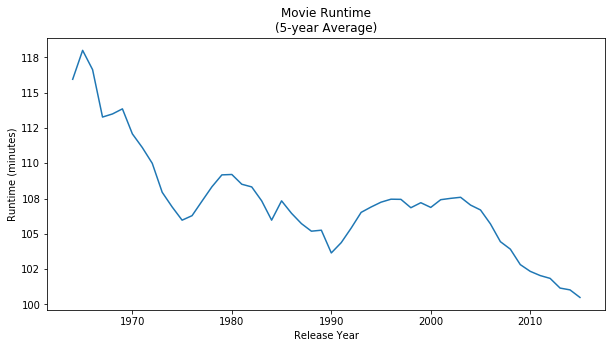

In [9]:
# AMPAS defines feature length as >=40m runtime
p = mdb[mdb['runtime'] >= 40]
p = p.groupby('release_year').mean()
p = p['runtime'].rolling(center=False, window=5).mean()

# create chart
ax = p.plot(title='Movie Runtime\n(5-year Average)', figsize=(10,5))
ax.set(xlabel='Release Year', ylabel='Runtime (minutes)')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'));

### What is the cost of a movie per finished minute?

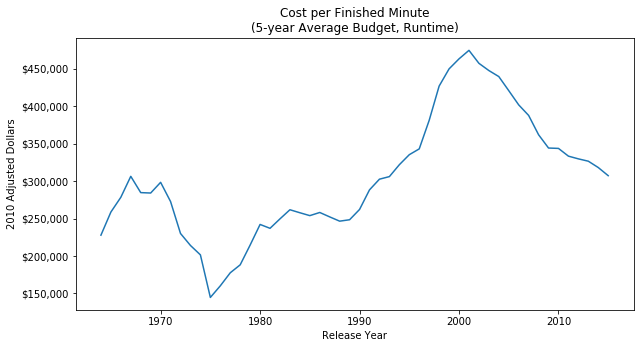

In [10]:
# include only movies that have budget and >=40m runtime; get 5-year rolling average
p = mdb[mdb['budget_adj'].notna() & (mdb['runtime'] >= 40)]
p = p.groupby('release_year').mean()
p = p[['budget_adj', 'runtime']].rolling(center=False, window=5).mean()
p['cost_per_min'] = p['budget_adj'] / p['runtime']

# create chart
ax = p['cost_per_min'].plot(title='Cost per Finished Minute\n(5-year Average Budget, Runtime)', figsize=(10,5))
ax.set(xlabel='Release Year', ylabel='2010 Adjusted Dollars')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'));

### How have the most popular genres changed over time?

In [271]:
# Calculate % of movies released by each Genre, Release Year group
k = pd.merge(mdb, gdb, left_index=True, right_on='id')
k = k.groupby(['release_year', 'genres'])[['id']].count()
k = k.groupby(['release_year']).apply(lambda x: round(100 * x / float(x.sum()),1))
k.rename(columns={'id': 'pct_by_year_genre'}, inplace=True)
k = k.reset_index(level='genres')
k.sort_index(inplace=True)
k




#k = k.reset_index()
#k.plot.area()
#k = k.nlargest(5, columns=['pct_by_year_genre'])

#k
#k = k.unstack('genres').unstack('release_year').reset_index()
#k
#k.plot.area()

,genres,pct_by_year_genre
release_year,,
1960,Action,10.3
1960,Adventure,6.4
1960,Comedy,10.3
1960,Crime,2.6
1960,Drama,16.7
1960,Family,3.8
1960,Fantasy,2.6
1960,Foreign,1.3
1960,History,6.4


In [186]:
k.index.levels[1].tolist()

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [189]:
a = sorted(k.index.get_level_values('genres').unique().tolist(), key=str.lower)
a

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'TV Movie',
 'War',
 'Western']

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!

AttributeError: 'AxesSubplot' object has no attribute 'show'

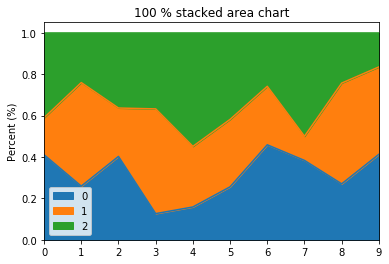

In [233]:
np.random.seed(2015)

y = np.random.randint(5, 50, (10,3))
x = np.arange(10)
df = pd.DataFrame(y, index=x)

df = df.divide(df.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, title='100 % stacked area chart')

ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace";

#plt.show()